# Spectra

Here you will learn how to obtain field-free and -dressed molecular spectra. First Richmol's `spectrum` module is imported:

In [1]:
from richmol import spectrum

A new-format Richmol file, containing energies of field-free states and matrix elements of field tensor operators for water, is downloaded from `zenodo`:

In [2]:
import urllib.request
import os
import h5py

# GET RICHMOL FILE
richmol_file = "h2o_p48_j40_emax4000_rovib.h5"
if not os.path.exists(richmol_file):
    url = "https://zenodo.org/record/4986069/files/h2o_p48_j40_emax4000_rovib.h5"
    print(f"download richmol file from {url}")
    urllib.request.urlretrieve(url, "h2o_p48_j40_emax4000_rovib.h5")
    print("download complete")

download richmol file from https://zenodo.org/record/4986069/files/h2o_p48_j40_emax4000_rovib.h5
download complete


This new-format Richmol file contains following datasets:

In [3]:
with h5py.File(richmol_file, "r") as fl:
    print("Available datasets")
    for key, val in fl.items():
        print(f"'{key}'")                   # dataset name
        print("\t", val.attrs["__doc__"])   # dataset description

Available datasets
'dipole'
	 Cartesian tensor operator, store date: 2021-06-18 17:57:50, comment: electric dipole moment in Debye, dipole moment surface: [DOI:10.1063/1.5043545]
'h0'
	 Cartesian tensor operator, store date: 2021-06-18 17:56:49, comment: Authors: Andrey Yachmenev (CFEL/DESY) and Sergei Yurchenko (UCL/London). TROVE variationally calculated of ro-vibrational energies and transitions for water H_2^16O. The data is truncated at energies below 4000 cm^-1. Basis: P48, J: 0..40, PES: [DOI:10.1098/rsta.2017.0149]. Calculated ro-vibrational energies substituted by empirical values from [DOI:10.1016/j.jqsrt.2012.10.002] where available. This data was produced in the following works [DOI:10.1103/PhysRevResearch.2.023091], [DOI:10.1039/D0CP01667E]. Notes on state assignment: the k-group rovibrational assignment is given by a string containing rovibrational quanta in the following order 'k tau v1 v2 v3 rot_sym vib_sym repl', where k and tau are rotational quantum numbers, v1, v2, 

## Field-free spectrum

The field-free spectrum of the electric dipole moment of water is obtained.

### Initialization

For initialization of a `FieldFreeSpec` object, the path to the Richmol file itself and the names of datasets containing field-free states and matrix elements of field tensor operator of interest need to be given. Furthermore, the keyword arguments `type` (coupling moment type), `order` (coupling moment order) and `units` (coupling moment units) can be used. These keyword arguments ensure application of correct selection rules, absorption intensity function and unit conversion factors during computations. To narrow down molecular states of interest, the keyword arguments `j_max` (maxiumum value of J / F quantum number) and `e_max` (maximum value of energy) are available:

In [4]:
# INITIALIZATION
free_spec = spectrum.FieldFreeSpec(
    richmol_file,
    names = ['h0', 'dipole'],
    type = 'elec',
    order = 'dip',
    units = 'Debye',
    j_max = 10,
    e_max = 1e4
)

When intializing a `FieldFreeSpec` object from old-format Richmol files, the keyword argument `names` is replaced by the keyword argument `matelem`, which represents the path to old-format Richmol files containing matrix elements of the field tensor operator of interest. Note that in this case the argument `richmol_file` represents the path to an old-format Richmol file containing energies of field-free states.

During intialization a path to a spectrum file, into which important results will be written, is created:

In [5]:
print('spectrum file : ', free_spec.out_f)

spectrum file :  dip_jmax10.0.hdf5


### Linestrength

To obtain linestrengths the `linestr()` function is called. The keywword argument `thresh` is used to define the linestrength threshold below which to neglect transitions:

In [6]:
# LINESTRENGTH
free_spec.linestr(thresh=1e-20)


  COMPUTED ASSIGNMENTS ...

      filename = h2o_p48_j40_emax4000_rovib.h5
      j_min = 0.0
      j_max = 10.0
      e_max = 10000.0

  COMPUTED LINESTRENGTHS ...

      filename = h2o_p48_j40_emax4000_rovib.h5
      type = elec
      order = dip
      linestr_thresh = 1e-20


Computed assignments and linestrengths have now been written to datasets of the groups 'assign' and 'spec' of the spectrum file.

### Absorption intensity

Finally the absorption intensities can be computed by calling the function `abs_intens()`. The keyword arguments `abun` (natural terrestrial isotopic abundance), `temp` (temperature), `part_sum` (total internal partition sum) and `thresh` (absorption intensity threshold below which to neglect transitions) can be used to obtain a customized solution.

In this computational step transitions and their corresponding absorption intensities can additionaly be filtered to ones liking (e.g. into transitions, which are allowed / forbidden w.r.t. nuclear spin). To do so, just pass the keyword argument `filter`, which represents a list containing filtering functions making use of the keyword arguments `sym` (total symmetry of states) and `qstr` (string containing other physical quanities of states). By default no filtering will be applied:

In [7]:
# ABSORPTION INTENSITY
temp = 296.0
part_sum = 174.5813
free_spec.abs_intens(temp, part_sum, abun=1.0, thresh=1e-36)


  COMPUTED ABSORPTION INTENSITIES ...

      type = elec
      order = dip
      units = Debye
      abun = 1.0
      temp = 296.0
      part_sum = 174.5813

  FILTERED ABSORPTION INTENSITIES ...

      abs_intens_thresh = 1e-36
      filters = ['all_']

  PLOTTED ABSORPTION INTENSITIES ...

      abs_intens_thresh = 1e-36
      filters = ['all_']



The datasets of the group 'spec' of the spectrum file have now been updated with the computed absorption intensities. Since no filters were applied here, a new contiguous dataset 'all_', which contains the whole spectrum, has been created. Also an absorption intensity plot has been saved to the current working directory.

To show absorption intensities in this example, a plot is created manually:

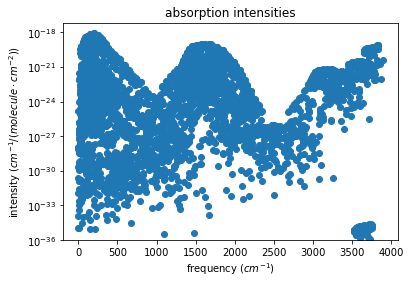

In [8]:
import matplotlib.pyplot as plt

# PLOT
with h5py.File(free_spec.out_f, 'r') as spec_file:
    spec = spec_file['all_'][:]
    plt.scatter(spec['freq'], spec['intens'])
plt.xlabel(r'frequency ($cm^{-1}$)')
plt.ylabel(r'intensity ($cm^{-1}$/($molecule \cdot cm^{-2}$))')
plt.yscale('log')
plt.ylim(bottom = free_spec.abs_intens_thresh)
plt.title('absorption intensities')
plt.show()